In this file, the goal is to visualize the cross entropy for all the regions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import ks_2samp
from scipy import stats

In [2]:

def read_error_csv(path):

    if os.path.exists(path):
        df = pd.read_csv(path)
        return df
    return None

In [3]:
Participants_epilepsy=pd.read_csv("/neurospin/dico/data/human/epilepsy_PBS/participants.tsv", sep="\t")

In [4]:
epilepsy_controls= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="controls"]
epilepsy_irm_neg= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_negatives_centrales"]
epilepsy_irm_pos= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="irm_positives_centrales"]

In [5]:
def separate_epilepsy_PBS(error_epilepsy): #To separate the reconstruction error into controls, irm_neg and irm_pos
    error_epilepsy  = error_epilepsy.rename(columns={error_epilepsy.columns[0]: "Index"})

    error_control = error_epilepsy.merge(epilepsy_controls[["Index"]], on="Index", how="inner")
    error_neg = error_epilepsy.merge(epilepsy_irm_neg[["Index"]], on="Index", how="inner")
    error_pos = error_epilepsy.merge(epilepsy_irm_pos[["Index"]], on="Index", how="inner")

    return error_control, error_neg, error_pos

In [6]:
dir_path= "/neurospin/tmp/fred/models/2025-11-10" 

In [7]:
import re

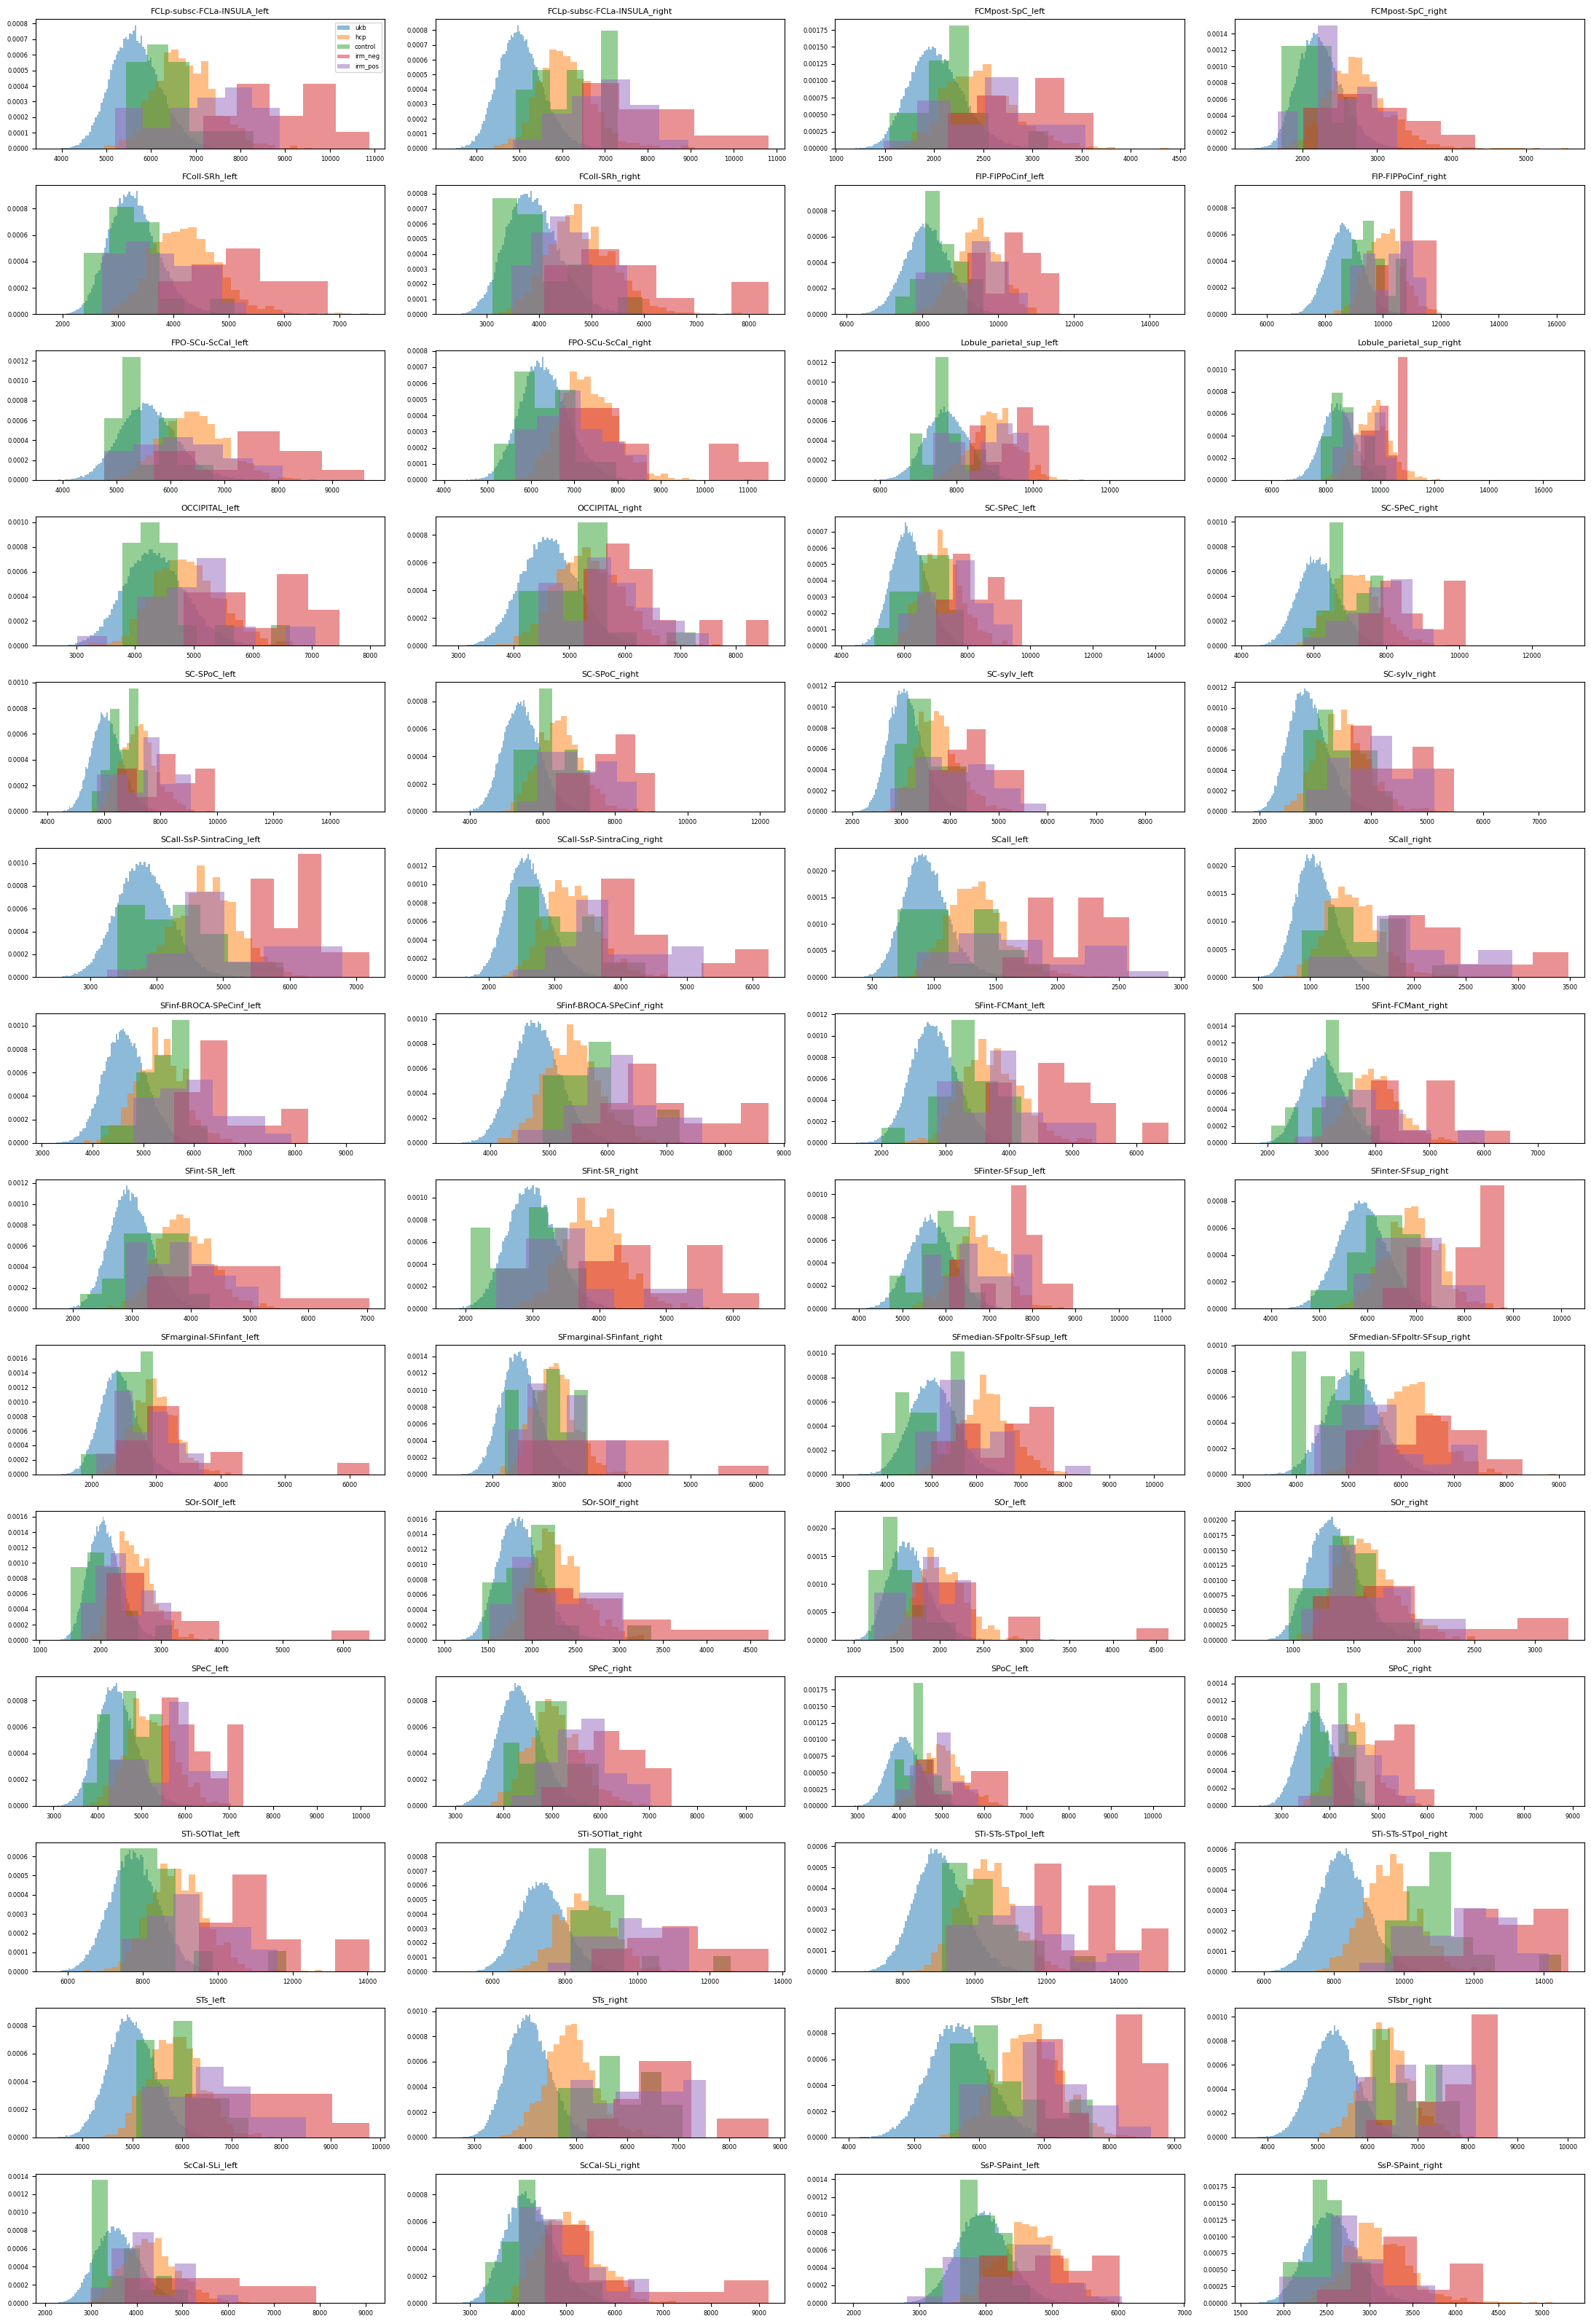


Tableau des distances de Kolmogorov smirnov :

                         regions  UKB and hcp  UKB and controls  \
0    FCLp-subsc-FCLa-INSULA_left     0.647411          0.436943   
1   FCLp-subsc-FCLa-INSULA_right     0.654335          0.611514   
2               FCMpost-SpC_left     0.519496          0.275385   
3              FCMpost-SpC_right     0.541608          0.213353   
4                 FColl-SRh_left     0.636770          0.159856   
5                FColl-SRh_right     0.598736          0.131814   
6             FIP-FIPPoCinf_left     0.748861          0.378150   
7            FIP-FIPPoCinf_right     0.735406          0.544853   
8             FPO-SCu-ScCal_left     0.561295          0.283265   
9            FPO-SCu-ScCal_right     0.616849          0.099220   
10      Lobule_parietal_sup_left     0.714743          0.160459   
11     Lobule_parietal_sup_right     0.713971          0.286526   
12                OCCIPITAL_left     0.377226          0.192076   
13            

In [8]:

subfolders = sorted([
    f for f in os.listdir(dir_path)
    if os.path.isdir(os.path.join(dir_path, f))
])


rows, cols = 14, 4
total_plots = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(22, 32))
axes = axes.flatten()

# Table to  save the ks distance
ks_table = pd.DataFrame(columns=["regions", "UKB and hcp", "UKB and controls", "controls and irm_neg", "controls and irm_pos"])

statistcs_UKB= pd.DataFrame(columns= ["regions", "mean", "median", "Interquantile range"])


for i, folder in enumerate(subfolders):
    regions=re.match(r"(.*?(left|right))", folder).group(1)

    ax = axes[i]
    current_path = os.path.join(dir_path, folder)

    ukb_file = os.path.join(current_path, "Reconstruction_error.csv")
    hcp_file = os.path.join(current_path, "hcp", "Reconstruction_error.csv")
    epi_file = os.path.join(current_path, "epilepsy_PBS", "Reconstruction_error.csv")
    #print(ukb_file)

    # lecture
    error_ukb = read_error_csv(ukb_file)
    error_hcp = read_error_csv(hcp_file)
    error_epilepsy = read_error_csv(epi_file)
    #print(len(error_ukb))

    error_control, error_neg, error_pos= separate_epilepsy_PBS(error_epilepsy)


    ax.hist(error_ukb.iloc[:,1], density=True, alpha=0.5, label="ukb", bins="auto")
    ax.hist(error_hcp.iloc[:,1], density=True, alpha=0.5, label="hcp", bins="auto")
    ax.hist(error_control.iloc[:,1], density=True, alpha=0.5, label="control", bins="auto")
    ax.hist(error_neg.iloc[:,1], density=True, alpha=0.5, label="irm_neg", bins="auto")
    ax.hist(error_pos.iloc[:,1], density=True, alpha=0.5, label="irm_pos", bins="auto")

    ax.set_title(regions, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    if i == 0:
        ax.legend(fontsize=6)

    # KS distances

    ks_ukb_hcp = ks_2samp(error_ukb.iloc[:,1], error_hcp.iloc[:,1]).statistic
    ks_ukb_control = ks_2samp(error_ukb.iloc[:,1], error_control.iloc[:,1]).statistic
    ks_control_neg = ks_2samp(error_control.iloc[:,1], error_neg.iloc[:,1]).statistic
    ks_control_pos = ks_2samp(error_control.iloc[:,1], error_pos.iloc[:,1]).statistic

    ks_table.loc[i] = [regions, ks_ukb_hcp, ks_ukb_control, ks_control_neg, ks_control_pos]

    #Statistics on UKB
    moy= np.mean(error_ukb)
    mediane = np.median(error_ukb)
    iqr = stats.iqr(error_ukb)

    statistcs_UKB.loc[i]= [regions, moy, mediane, iqr]

plt.tight_layout()
plt.show()

# Affichage final du tableau KS
print("\nTableau des distances de Kolmogorov smirnov :\n")
print(ks_table)


In [9]:
ks_table.to_csv("Kolmogorov Smirnov distance with cross entropy loss")

In [10]:
ks_table["UKB and controls"].mean()

np.float64(0.41619532800847125)

In [11]:
min(ks_table["UKB and controls"])

0.09922019480865807

In [12]:
max(ks_table["UKB and controls"])

0.9478943275281031

In [14]:
ks_table["UKB and controls"].to_csv("UKB and controls")

In [134]:
names= ks_table.iloc[:,0]

#  Moyenne des deux dernières colonnes
value = ks_table.iloc[:, -2:].mean(axis=1)



In [135]:
visualize_distance= pd.DataFrame({ "region": names,
                                  "p": value})

visualize_distance

,region,p
0,FCLp-subsc-FCLa-INSULA_left,0.748421
1,FCLp-subsc-FCLa-INSULA_right,0.584211
2,FCMpost-SpC_left,0.644130
3,FCMpost-SpC_right,0.640405
4,FColl-SRh_left,0.650526
5,FColl-SRh_right,0.657328
6,FIP-FIPPoCinf_left,0.714737
7,FIP-FIPPoCinf_right,0.617814
8,FPO-SCu-ScCal_left,0.676275
9,FPO-SCu-ScCal_right,0.629960


In [136]:
visualize_distance.to_csv("Distance_between_controls_and_patients")

In [137]:
sorted_distance = visualize_distance.sort_values(by="p", ascending=False)
sorted_distance

,region,p
40,SPeC_left,0.761538
0,FCLp-subsc-FCLa-INSULA_left,0.748421
20,SCall-SsP-SintraCing_left,0.748421
27,SFint-FCMant_right,0.741053
44,STi-SOTlat_left,0.734737
21,SCall-SsP-SintraCing_right,0.723158
29,SFint-SR_right,0.714737
6,FIP-FIPPoCinf_left,0.714737
12,OCCIPITAL_left,0.702105
50,STsbr_left,0.702105


In [138]:
sorted_distance.to_csv("sorted_distance")

In [139]:
sorted_statistics_UKB = statistcs_UKB.sort_values(by="mean", ascending=False)

In [140]:
sorted_statistics_UKB.to_csv("Statistics on cross entropy loss among UKB subjects using betaVAE")